#Explorando a rede de páginas da Wikipédia

Neste notebook buscamos contruir um grafo direcionado a partir das páginas da Wikipédia, onde os nós, ou vértices, são as páginas e as arestas são os links contidos nessas páginas. Como existem ❗milhões❗ de páginas, nos limitaremos a explorar apenas duas camadas. Sendo a primeira camada composta por um nó raiz e a próxima camada composta pelos nós que se conectam ao primeiro. A página escolhida como nó raiz é sobre [vertebrados](https://en.wikipedia.org/wiki/Vertebrate).

Exploraremos diversas métricas aplicadas a este grafo, como as de centralidade, entre elas estão: 

* *degree centrality*, que mede o número de conexões entre os nós da rede. Como nesse caso é uma rede direcionada, deve se levar em conta a entrada e a saída nos nos nós;
* *closeness centrality*, que mede o caminho mais curto e nos dá informações sobre o quão perto um determinado nó está dos outros nós;
* *betweenness centrality*, que é uma porcentagem dos caminhos mais curtos que um nó faz parte e nos dá informações sobre o quanto o fluxo de informação passa por ele;

* *eingenvector centrality*, que observa a qualidade dos vizinhos e indica que somos importantes se temos vizinhos importantes.

Além disso, as métricas coletadas serão exploradas estatisticamente através da geração da função de densidade cumulativa (do inglês, *cumulative density function* ou CDF) e da função densidade de probabilidade (do inglês, *probability density function* ou PDF).

A partir dessas análises, será observada a formação de *hubs*, ou seja, quando há poucos nós com muitas conexões para se identificar o *core* ou núcleo da rede.

Todas essas tarefas serão realizadas usando um **pipeline de dados** construído para este fim.

##Preparando o ambiente

Primeiramente, daremos acesso a um diretório pessoal no google drive para salvar os dados sobre esta rede a ser criada, bem como os gráficos que serão gerados a partir das métricas citadas.

In [ ]:
import os

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!ls

gdrive	sample_data


In [ ]:
path = "gdrive/My Drive/UFRN/7_SEMESTRE/ALGORITMOS_E_ESTRUTURAS_DE_DADOS_II_DCA0209/T3U2"

In [ ]:
os.chdir(path)

## Importando bibliotecas

In [1]:
# always check the current version in github
!pip install networkx==2.6.3

In [2]:
!pip install wikipedia

In [3]:
from operator import itemgetter
import networkx as nx
import wikipedia
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import deque
import numpy as np
import seaborn as sns
import pandas as pd

In [ ]:
#checando a versão do networkx
nx.__version__

'2.6.3'

##Pipeline


### Criando o pipeline

In [20]:
class Pipeline():
    def __init__(self):
        self.tasks = []
        
    def task(self, depends_on=None):
        index = 0
        if depends_on:
            index = self.tasks.index(depends_on) + 1
        def inner(f):
            self.tasks.insert(index, f)
            return f
        return inner
    
    def run(self, input_):
        output = input_
        for task in self.tasks:
            output = task(output)
        return output

In [21]:
#instantiate the class
pipeline = Pipeline()

### Adicionando funções

In [22]:
# data collecting
@pipeline.task()
def get(SEED):
  STOPS = ("Bibcode (Identifier)",
          "Doi (Identifier)",
          "Isbn (Identifier)",
          "Issn (Identifier)",
          "Jstor (Identifier)",
          "Muséum National D'Histoire Naturelle",
          "Oclc (Identifier)",
          "Pmc (Identifier)",
          "Pmid (Identifier)",
          "S2Cid (Identifier)"
          "The Columbia Electronic Encyclopedia")
  
  todo_lst = [(0, SEED)] # The SEED is in the layer 0
  todo_set = set(SEED) # The SEED itself
  done_set = set()

  g = nx.DiGraph()
  layer, page = todo_lst[0]
  
  while layer < 2:
    # Remove the name page of the current page from the todo_lst, 
    # and add it to the set of processed pages. 
    # If the script encounters this page again, it will skip over it.
    del todo_lst[0]
    done_set.add(page)
  
    # Show progress
    #print(layer, page) 
  
    # Attempt to download the selected page.
    try:
      wiki = wikipedia.page(page)
    except:
      print("Could not load", page)
      layer, page = todo_lst[0]
      continue
  
    for link in wiki.links:
      link = link.title()
      if link not in STOPS and not link.startswith("List Of"):
        if link not in todo_set and link not in done_set:
          todo_lst.append((layer + 1, link))
          todo_set.add(link)
        g.add_edge(page, link)
    layer, page = todo_lst[0]

  return g

In [23]:
# data cleaning
@pipeline.task(depends_on=get)
def clean(g):

  # remove self loops
  g.remove_edges_from(nx.selfloop_edges(g))

  # identify duplicates like that: 'network' and 'networks'
  duplicates = [(node, node + "s") 
                for node in g if node + "s" in g
                ]

  for dup in duplicates:
    # *dup is a technique named 'unpacking'
    g = nx.contracted_nodes(g, *dup, self_loops=False)

  print(duplicates)

  duplicates = [(x, y) for x, y in 
                [(node, node.replace("-", " ")) for node in g]
                  if x != y and y in g]
  print(duplicates)

  for dup in duplicates:
    g = nx.contracted_nodes(g, *dup, self_loops=False)

  # nx.contracted creates a new node/edge attribute called contraction
  # the value of the attribute is a dictionary, but GraphML
  # does not support dictionary attributes
  nx.set_node_attributes(g, 0,"contraction")
  nx.set_edge_attributes(g, 0,"contraction")

  return g

In [24]:
# exclude the last two shells
@pipeline.task(depends_on=clean)
def truncate(g):
  # filter nodes with degree greater than or equal to 2
  core = [node for node, deg in dict(g.degree()).items() if deg >= 2]

  # select a subgraph with 'core' nodes
  gsub = nx.subgraph(g, core)

  nx.write_graphml(gsub, "vertebrate.graphml")

In [25]:
#visualizar os vertices e arestas da rede
@pipeline.task(depends_on=truncate)
def shownodesedges(self):
  g = nx.read_graphml("vertebrate.graphml")

  print("{} nodes, {} edges".format(len(g), nx.number_of_edges(g)))

In [26]:
# draw graphs based on metrics about centrality
@pipeline.task(depends_on=shownodesedges)
def graph_metrics(self):
  g = nx.read_graphml("vertebrate.graphml")

  # draw 
  fig, ax = plt.subplots(2,2,figsize=(10,8))

  # max value of metrics 
  max_centrality = max([max([v for k, v in nx.eigenvector_centrality(g).items()]),
                        max([v for k, v in nx.degree_centrality(g).items()]),
                        max([v for k, v in nx.closeness_centrality(g).items()]),
                        max([v for k, v in nx.betweenness_centrality(g).items()])])

  # layout position
  pos = nx.spring_layout(g,seed=123456789,k=0.3)

  # color of nodes
  color_degree = list(dict(nx.degree_centrality(g)).values())
  color_closeness = list(dict(nx.closeness_centrality(g)).values())
  color_betweenness = list(dict(nx.betweenness_centrality(g)).values())
  color_eigenvector = list(dict(nx.eigenvector_centrality(g)).values())

  # 
  # draw edges
  #
  # degree centrality
  nx.draw_networkx_edges(g,
                        pos=pos,
                        alpha=0.4, ax=ax[0,0])

  # closeness centrality
  nx.draw_networkx_edges(g,
                        pos=pos,
                        alpha=0.4, ax=ax[0,1])

  # betweenness centrality
  nx.draw_networkx_edges(g,
                        pos=pos,
                        alpha=0.4, ax=ax[1,0])

  # eigenvector centrality
  nx.draw_networkx_edges(g,
                        pos=pos,
                        alpha=0.4, ax=ax[1,1])

  # draw nodes
  nodes = nx.draw_networkx_nodes(g,
                  pos=pos,
                  node_color=color_degree,
                  cmap=plt.cm.jet,vmin=0,vmax=max_centrality,
                  ax=ax[0,0])
  nodes = nx.draw_networkx_nodes(g,
                  pos=pos,
                  node_color=color_closeness,
                  cmap=plt.cm.jet,vmin=0,vmax=max_centrality,
                  ax=ax[0,1])
  nodes = nx.draw_networkx_nodes(g,
                  pos=pos,
                  node_color=color_betweenness,
                  cmap=plt.cm.jet,vmin=0,vmax=max_centrality,
                  ax=ax[1,0])
  nodes = nx.draw_networkx_nodes(g,
                  pos=pos,
                  node_color=color_eigenvector,
                  cmap=plt.cm.jet,vmin=0,vmax=max_centrality,
                  ax=ax[1,1])

  # 
  # draw labels
  #
  nx.draw_networkx_labels(g, pos=pos,
                          font_color='white', ax=ax[0,0])
  nx.draw_networkx_labels(g, pos=pos,
                          font_color='white', ax=ax[0,1])
  nx.draw_networkx_labels(g, pos=pos,
                          font_color='white', ax=ax[1,0])
  nx.draw_networkx_labels(g, pos=pos,
                          font_color='white', ax=ax[1,1])

  # eliminate axis
  ax[0,0].axis("off")
  ax[1,0].axis("off")
  ax[0,1].axis("off")
  ax[1,1].axis("off")

  ax[0,0].set_title("Degree Centrality")
  ax[0,1].set_title("Closeness Centrality")
  ax[1,0].set_title("Betweenness Centrality")
  ax[1,1].set_title("Eigenvector Centrality")


  # Create an unique colorbar
  # reference: https://stackoverflow.com/questions/60848582/unique-colorbar-at-the-right-of-multiple-subplots
  plt.subplots_adjust(bottom=0., right=0.92, top=1.)
  cax = plt.axes([0.95, 0.3, 0.025, 0.4])
  sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=0, vmax=max_centrality))
  cbar=plt.colorbar(sm,cax)

  plt.savefig('alltogether.png', transparent=True,dpi=600,bbox_inches="tight")
  plt.show()

In [27]:
# based on metrics, draw PDF
@pipeline.task(depends_on=graph_metrics)
def pdf(self):
  g = nx.read_graphml("vertebrate.graphml") 

  degree_sequence = sorted([d for n, d in g.degree()], reverse=True)
  
  plt.style.use("fivethirtyeight")
  #plt.style.use("default")

  fig, ax = plt.subplots(1,1,figsize=(10,8))

  sns.histplot(degree_sequence,bins=7,label="Count",ax=ax)
  ax2 = ax.twinx()
  sns.kdeplot(degree_sequence,color='r',label="Probability Density Function (PDF)",ax=ax2)

  # ask matplotlib for the plotted objects and their labels
  lines, labels = ax.get_legend_handles_labels()
  lines2, labels2 = ax2.get_legend_handles_labels()
  ax2.legend(lines + lines2, labels + labels2, loc=0)

  ax.grid(False)
  ax2.grid(False)
  ax.set_xlabel("Degree")
  ax2.set_ylabel("Probability")

  plt.savefig('probability_density_function.png', transparent=True,dpi=600,bbox_inches="tight")
  plt.show()

In [28]:
# based on metrics, draw CDF
@pipeline.task(depends_on=pdf)
def cdf(self):
  g = nx.read_graphml("vertebrate.graphml")

  degree_sequence = sorted([d for n, d in g.degree()], reverse=True)

  plt.style.use("fivethirtyeight")
  #plt.style.use("default")

  fig, ax = plt.subplots(1,1,figsize=(10,8))

  sns.histplot(degree_sequence,bins=7,label="Count",ax=ax)
  ax2 = ax.twinx()
  sns.kdeplot(degree_sequence,color='r',label="Cumulative Density Function (CDF)",ax=ax2,cumulative=True)

  # ask matplotlib for the plotted objects and their labels
  lines, labels = ax.get_legend_handles_labels()
  lines2, labels2 = ax2.get_legend_handles_labels()
  ax2.legend(lines + lines2, labels + labels2, loc=0)

  ax.grid(False)
  ax2.grid(False)
  ax.set_xlabel("Degree")
  ax2.set_ylabel("Probability")

  plt.savefig('cumulative_density_function.png', transparent=True,dpi=600,bbox_inches="tight")
  plt.show()

In [29]:
# observe all centrality distributions
@pipeline.task(depends_on=cdf)
def centrality_distributions(self):
  g = nx.read_graphml("vertebrate.graphml")

  bc = pd.Series(nx.betweenness_centrality(g))
  dc = pd.Series(nx.degree_centrality(g))
  ec = pd.Series(nx.eigenvector_centrality(g))
  cc = pd.Series(nx.closeness_centrality(g))

  df = pd.DataFrame.from_dict({"Betweenness": bc,
                              "Degree": dc,
                              "EigenVector": ec,
                              "Closeness": cc})
  df.reset_index(inplace=True,drop=True)
  df.head()

  fig = sns.PairGrid(df)
  fig.map_upper(sns.scatterplot)
  fig.map_lower(sns.kdeplot, cmap="Reds_r")
  fig.map_diag(sns.kdeplot, lw=2, legend=False)

  plt.savefig('all.png', transparent=True,dpi=800,bbox_inches="tight")
  plt.show()

In [30]:
# destacar os cores com mais conexoes (57 e 61)
@pipeline.task(depends_on=centrality_distributions)
def draw_innermost_cores(self):
  g = nx.read_graphml("vertebrate.graphml")

  fig, ax = plt.subplots(1,1,figsize=(10,8))

  # Find k-cores
  g_core_57 = nx.k_shell(g, 57)
  g_core_61 = nx.k_core(g, 61)

  # layout position
  pos = nx.spring_layout(g,seed=123456789,k=0.3)

  # draw edges
  nx.draw_networkx_edges(g,
                        pos=pos,
                        alpha=0.4, ax=ax)

  # draw nodes
  nodes = nx.draw_networkx_nodes(g,
                  pos=pos,
                  node_color="#333333")

  # draw nodes
  nodes = nx.draw_networkx_nodes(g_core_57,
                  pos=pos,
                  node_color="blue")

  nodes = nx.draw_networkx_nodes(g_core_61,
                  pos=pos,
                  node_color="red")

  # static legend
  red_patch = mpatches.Patch(color='red', label='57-core')
  blue_patch = mpatches.Patch(color='blue', label='61-shell')
  plt.legend(handles=[red_patch,blue_patch])

  plt.axis("off")
  plt.savefig('k-core_vertebrate.png', transparent=True,dpi=600)
  plt.show()

###Ativando pipeline

Could not load Bee
Could not load Clam
Could not load Colossal Squid
Could not load Crab
Could not load Cycliophora
Could not load Diffusion
Could not load Eusocial
Could not load Fish
Could not load Gene
Could not load Gill
Could not load Head
Could not load Intron
Could not load Leech
Could not load Micrometre
Could not load Moulting
Could not load Sea Urchin
Could not load Sexual Reproduction
Could not load Sponge
Could not load Thrips
Could not load Tonian
Could not load Tunicata
Could not load Tunicate
Could not load Ventilation (Physiology)
Could not load Water
Could not load Worm
[('Vertebrate', 'Vertebrates'), ('Animal', 'Animals'), ('Annelid', 'Annelids'), ('Arachnid', 'Arachnids'), ('Arthropod', 'Arthropods'), ('Barnacle', 'Barnacles'), ('Bee', 'Bees'), ('Brittle Star', 'Brittle Stars'), ('Choanoflagellate', 'Choanoflagellates'), ('Chordate', 'Chordates'), ('Clam', 'Clams'), ('Cnidarian', 'Cnidarians'), ('Copepod', 'Copepods'), ('Coral', 'Corals'), ('Crab', 'Crabs'), ('Crusta

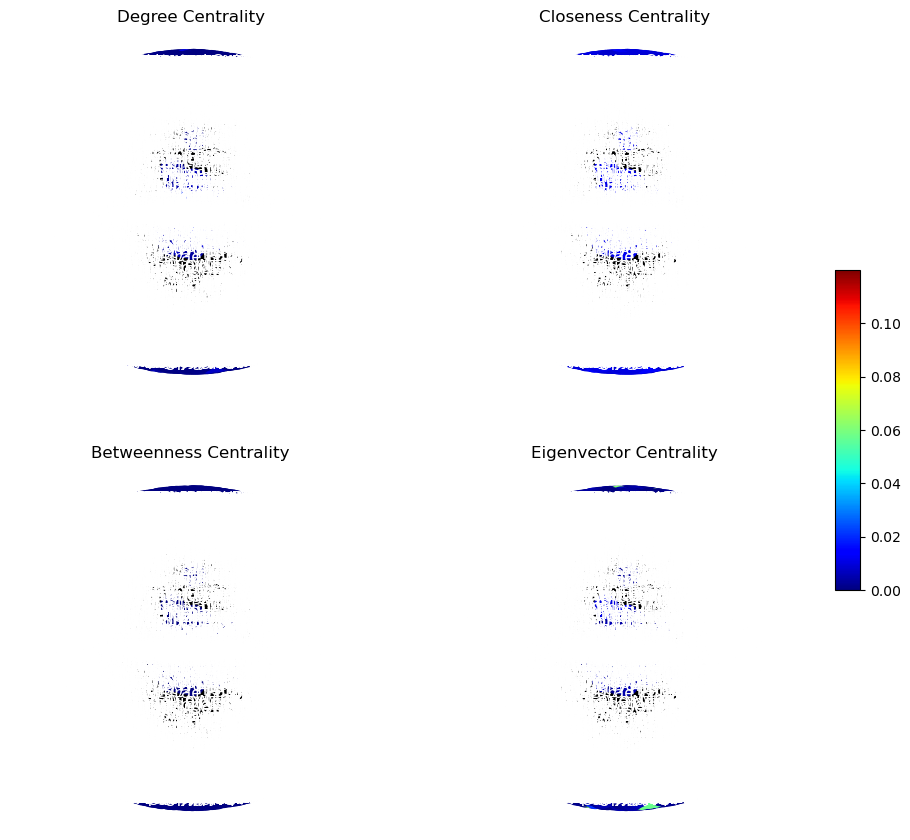

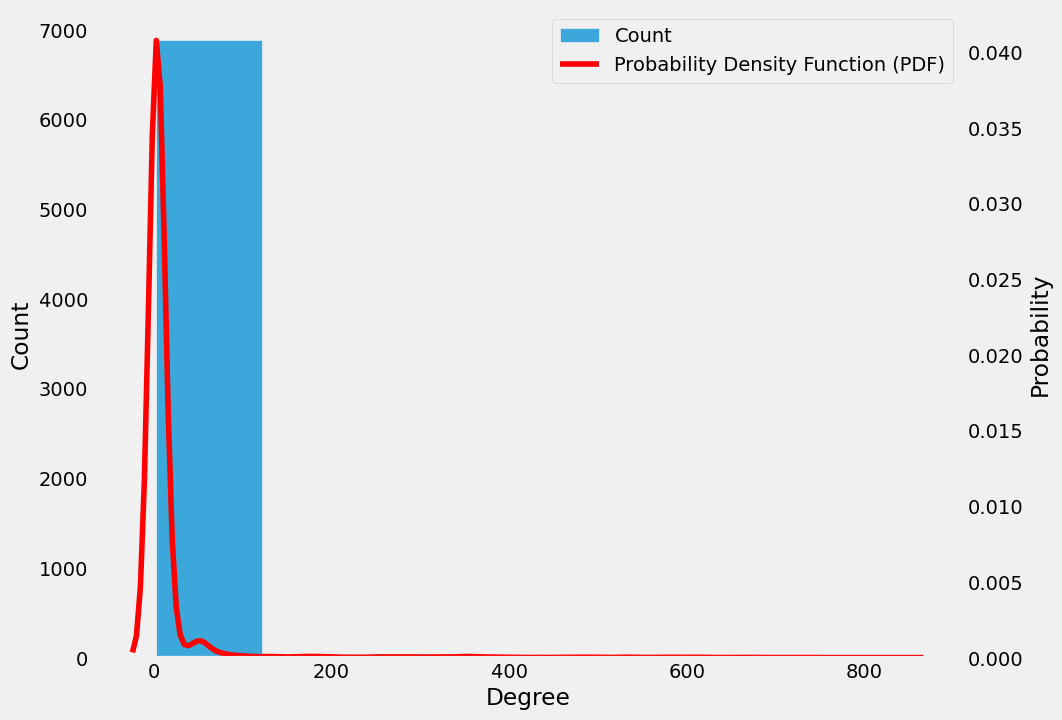

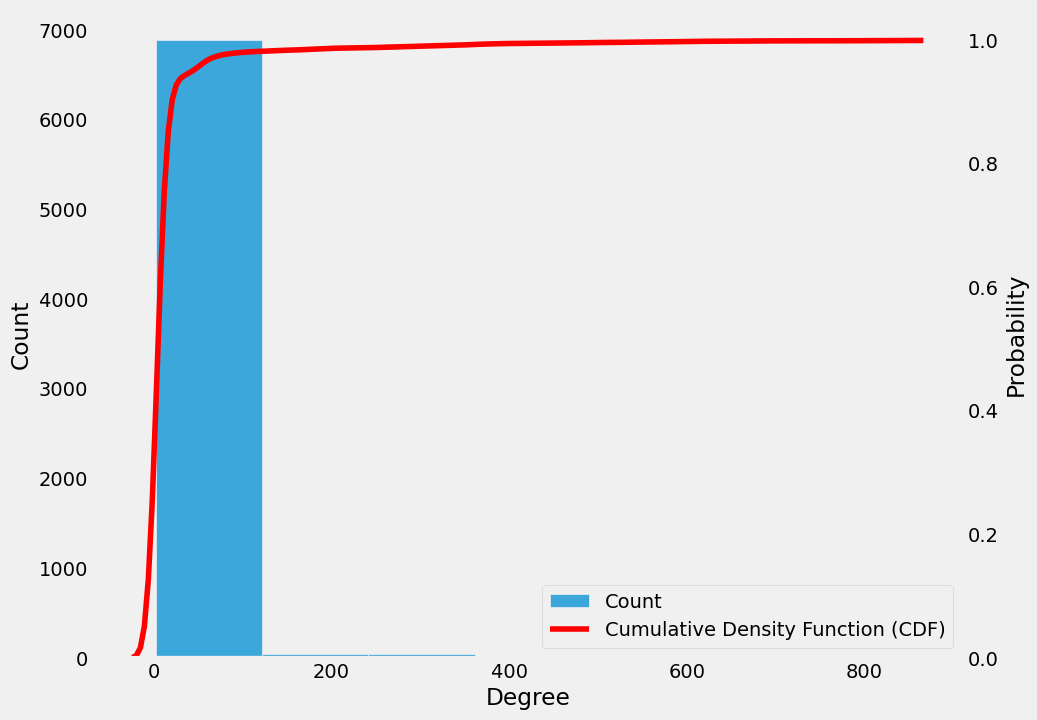

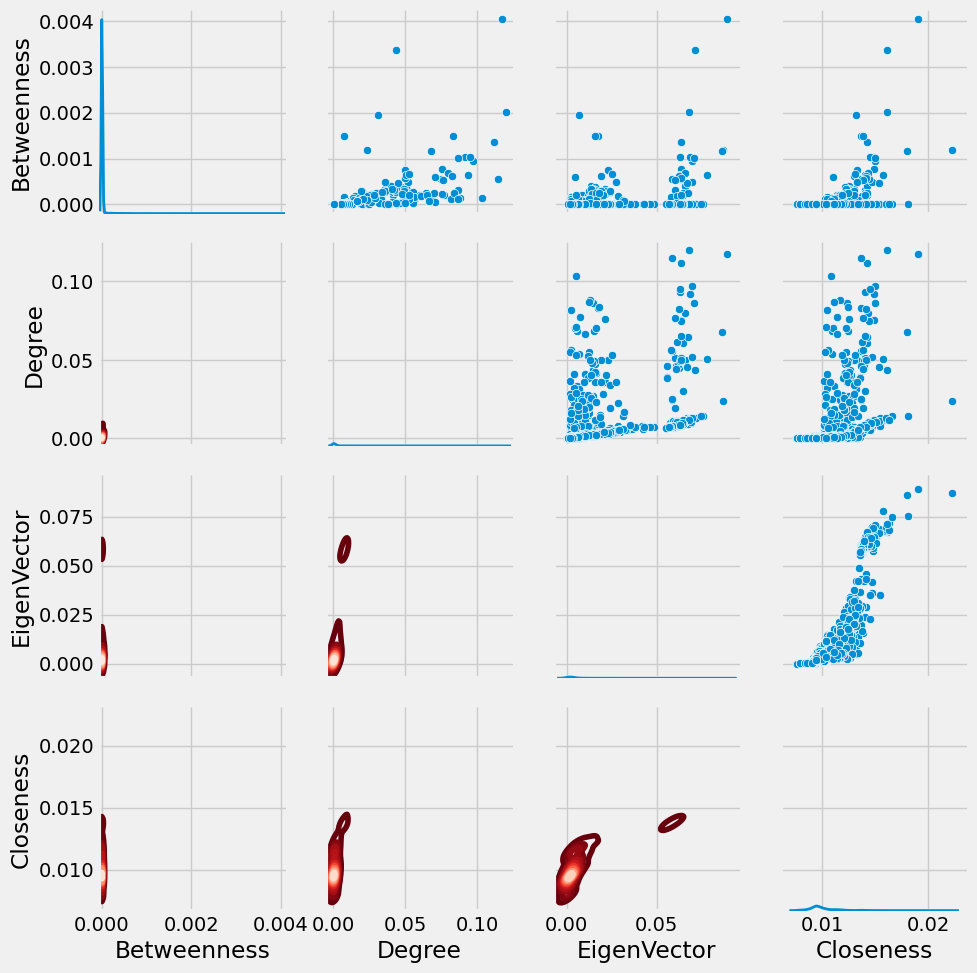

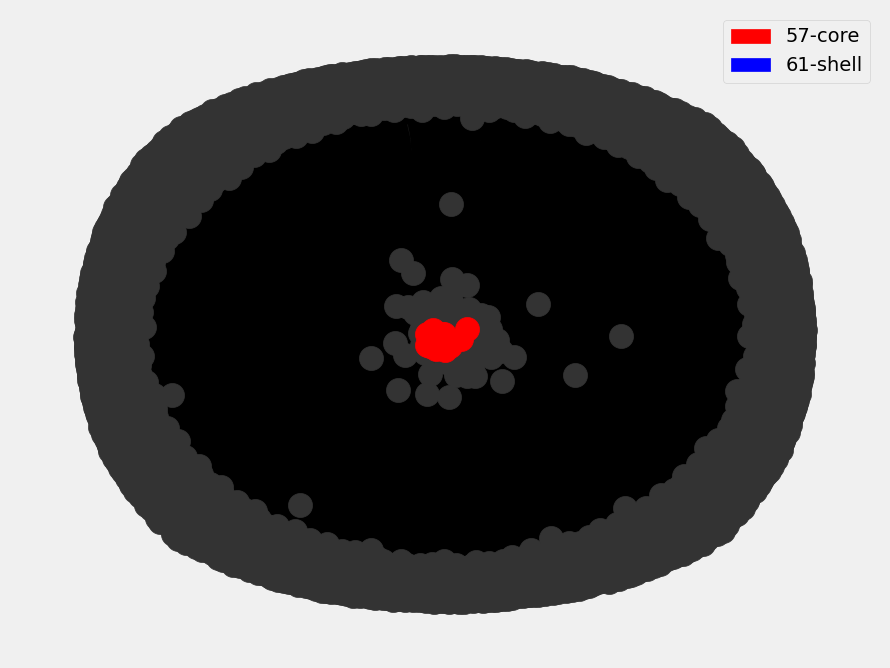

In [31]:
SEED = "Vertebrate".title()

outputs = pipeline.run(SEED)